In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split

from imblearn.over_sampling import SMOTE

In [ ]:
FILENAME = 'Feature_Track.xlsx'
TO_SHIFT = -1

In [ ]:
df = pd.read_excel(FILENAME)

def create_future_risk_evaluation(to_shift, df):
  df['future_risk_evaluation'] = df['risk_evaluation'].shift(TO_SHIFT)
  df_final = df
  for _ in range(abs(to_shift)):
    df_filtered = df[~df.duplicated(subset='subject', keep='last')]
    df_final = df.drop(df_filtered.index)
  return df_final

df.loc[df['risk_evaluation'] == 2, 'risk_evaluation'] = 1
df = create_future_risk_evaluation(TO_SHIFT, df)

In [ ]:
df.replace(np.nan, 0, inplace=True)

In [ ]:
df

,Unnamed: 0,subject,lap,start_time,straight,roundabout_entry,roundabout_exit,zebra_crossing,left_turn,u_turn,...,LowerAlphaParietal,UpperAlphaFrontal,UpperAlphaParietal,BetaFrontal,BetaParietal,LowerBetaFrontal,LowerBetaParietal,UpperBetaFrontal,UpperBetaParietal,future_risk_evaluation
0,0,0AC2A4,1,7,1,1,0,0,1,0,...,0.08812,0.13469,0.08590,0.05499,0.04078,0.08419,0.06275,0.03722,0.02711,0.0
1,1,0AC2A4,1,27,1,0,1,0,1,0,...,0.08118,0.12483,0.07588,0.04060,0.02869,0.05951,0.04759,0.02963,0.01753,0.0
2,2,0AC2A4,1,33,1,0,0,1,1,0,...,0.11480,0.10121,0.09079,0.04339,0.02727,0.06250,0.04305,0.03296,0.01751,0.0
3,3,0AC2A4,1,43,1,1,0,0,0,0,...,0.12873,0.11832,0.11087,0.04872,0.02917,0.06894,0.04766,0.03627,0.01744,0.0
4,4,0AC2A4,1,58,1,1,0,0,0,0,...,0.14454,0.13428,0.13604,0.04173,0.02743,0.05937,0.04344,0.03132,0.01762,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,1050,8924EA,7,99,0,0,0,0,1,0,...,0.09497,0.04877,0.06143,0.01402,0.01226,0.02569,0.02228,0.00680,0.00593,0.0
1051,1051,8924EA,7,104,0,1,0,1,0,0,...,0.05568,0.03106,0.04034,0.01196,0.01110,0.01724,0.01730,0.00886,0.00729,0.0
1052,1052,8924EA,7,112,0,0,1,1,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0
1053,1053,8924EA,7,115,0,0,0,0,1,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0


In [ ]:
df['future_risk_evaluation'].value_counts()

0.0    1001
1.0      39
Name: future_risk_evaluation, dtype: int64

In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
to_drop = ['subject', 'Unnamed: 0']
X = X.drop(columns=to_drop)

In [ ]:
# from imblearn.over_sampling import SMOTE
# import pandas as pd

# Assuming you have a DataFrame called 'df' with features and target variable
# 'X' contains features, 'y' contains target variable

# Assuming 'y' is your target variable
# X = df.drop('target_variable_name', axis=1)
# y = df['target_variable_name']

# Initialize SMOTE with desired sampling strategy
# For example, if you want to oversample the minority class to a specific number, say 1000 samples:
desired_samples = 200
smote = SMOTE(sampling_strategy={1: desired_samples})

# Apply SMOTE to your data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Now X_resampled and y_resampled contain the oversampled data
# You can convert them back to DataFrame if needed
oversampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)


In [ ]:
oversampled_df['future_risk_evaluation'].value_counts()

0.0    1001
1.0     200
Name: future_risk_evaluation, dtype: int64

In [ ]:
X = oversampled_df.iloc[:, 0:-1]
y = oversampled_df.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Find the best parameters

In [ ]:
# Define hyperparameters for each algorithm
gbdt_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [1e-3, 1e-2, 1e-1, 1],
    'max_depth': [1, 3, 5, 7, 9],
    'loss': ['deviance', 'exponential']
}

lr_params = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

mlp_params = {
    'hidden_layer_sizes': [(32,16,8,4), (32,16,4), (16,8,4)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'solver': ['adam', 'lbfgs', 'sgd']
}

rf_params = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'criterion': ['gini', 'entropy'],
    'max_features': [20, 21, 22, 23, 24, 25, 26, 27]
}

svm_params = {
    'C': [1, 1e1, 1e2, 1e3],
    'gamma': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define the models
models = {
    # 'Gradient Boosted Decision Trees': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Multilayer Perceptron': MLPClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

# Define hyperparameters for each model
parameters = {
    'Gradient Boosted Decision Trees': gbdt_params,
    'Logistic Regression': lr_params,
    'Multilayer Perceptron': mlp_params,
    'Random Forest': rf_params,
    'Support Vector Machine': svm_params
}

# Evaluation Metrics
def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return accuracy, precision, recall, f1, tn, fp, fn, tp

# Perform grid search with cross-validation
for name, model in models.items():
    print(f"Performing grid search with cross-validation for {name}...")
    clf = GridSearchCV(model, parameters[name], cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    print(f"Best parameters found: {clf.best_params_}")
    print(f"Best cross-validation accuracy: {clf.best_score_}")

    # Evaluate on test set
    test_score = clf.score(X_test, y_test)
    print(f"Accuracy on test set: {test_score}")

    # Print other evaluation metrics
    y_pred = clf.predict(X_test)
    accuracy, precision, recall, f1, tn, fp, fn, tp = evaluate(y_test, y_pred)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix: [[{tn} {fp}]\n [{fn} {tp}]]")
    print()


Performing grid search with cross-validation for Logistic Regression...
Best parameters found: {'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.9458333333333334
Accuracy on test set: 0.950207468879668
Precision: 0.9
Recall: 0.8181818181818182
F1 Score: 0.8571428571428572
Confusion Matrix: [[193 4]
 [8 36]]

Performing grid search with cross-validation for Multilayer Perceptron...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (32, 16, 8, 4), 'solver': 'adam'}
Best cross-validation accuracy: 0.925
Accuracy on test set: 0.9294605809128631
Precision: 0.813953488372093
Recall: 0.7954545454545454
F1 Score: 0.8045977011494252
Confusion Matrix: [[189 8]
 [9 35]]

Performing grid search with cross-validation for Random Forest...
Best parameters found: {'criterion': 'gini', 'max_features': 25, 'n_estimators': 70}
Best cross-validation accuracy: 0.9604166666666668
Accuracy on test set: 0.946058091286307
Precision: 0.9428571428571428
Recall: 0.75
F1 Score: 0.8354430379746834
Confusion Matrix: [[195 2]
 [11 33]]

Performing grid search with cross-validation for Support Vector Machine...


KeyboardInterrupt: 

# Apply ML Algorithms

Gradient Boosted Decision Trees...
Accuracy on test set: 0.941908713692946
Precision: 0.96875
Recall: 0.7045454545454546
F1 Score: 0.8157894736842106
Confusion Matrix: [[196 1]
 [13 31]]



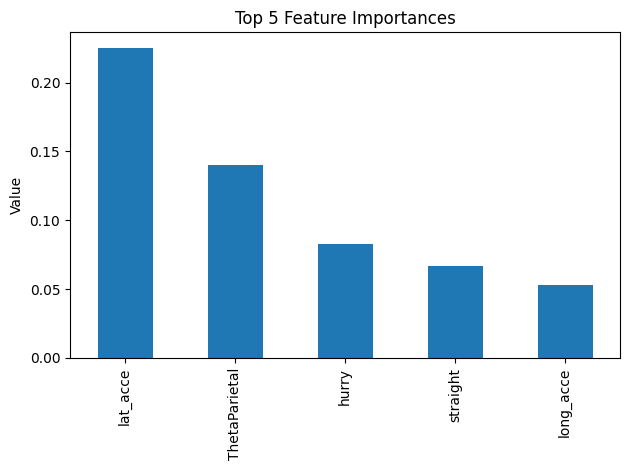

Logistic Regression...
Accuracy on test set: 0.9294605809128631
Precision: 0.8648648648648649
Recall: 0.7272727272727273
F1 Score: 0.7901234567901235
Confusion Matrix: [[192 5]
 [12 32]]

Multilayer Perceptron...
Accuracy on test set: 0.9087136929460581
Precision: 0.9583333333333334
Recall: 0.5227272727272727
F1 Score: 0.6764705882352942
Confusion Matrix: [[196 1]
 [21 23]]

Random Forest...
Accuracy on test set: 0.950207468879668
Precision: 0.9444444444444444
Recall: 0.7727272727272727
F1 Score: 0.85
Confusion Matrix: [[195 2]
 [10 34]]



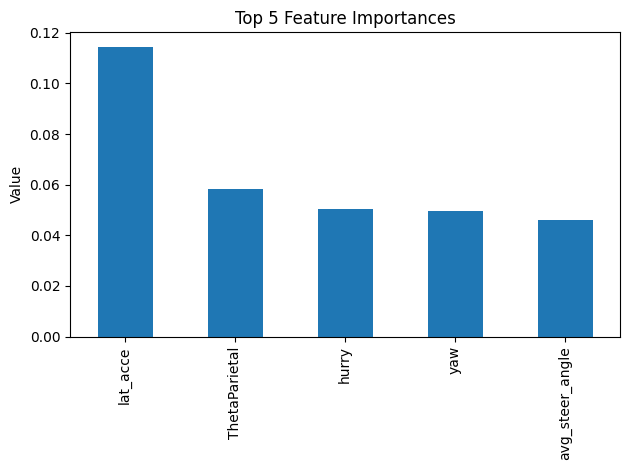

Support Vector Machine...
Accuracy on test set: 0.8423236514522822
Precision: 0.6666666666666666
Recall: 0.2727272727272727
F1 Score: 0.3870967741935484
Confusion Matrix: [[191 6]
 [32 12]]



In [ ]:
X_train_columns = X_train.columns
# Define the models
models = {
    'Gradient Boosted Decision Trees': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(penalty='l2', solver='liblinear'),
    'Multilayer Perceptron': MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(32, 16, 8, 4), solver='adam'),
    'Random Forest': RandomForestClassifier(criterion='gini', max_features=25, n_estimators=70),
    'Support Vector Machine': SVC()
}

# Evaluation Metrics
def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return accuracy, precision, recall, f1, tn, fp, fn, tp

for name, model in models.items():
    print(f"{name}...")
    clf = model
    clf.fit(X_train, y_train)

    # Evaluate on test set
    test_score = clf.score(X_test, y_test)
    print(f"Accuracy on test set: {test_score}")

    # Print other evaluation metrics
    y_pred = clf.predict(X_test)
    accuracy, precision, recall, f1, tn, fp, fn, tp = evaluate(y_test, y_pred)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix: [[{tn} {fp}]\n [{fn} {tp}]]")
    print()
    if name in ['Gradient Boosted Decision Trees', 'Random Forest']:
      feature_importance = clf.feature_importances_
      series_importances = pd.Series(feature_importance, index=X_train_columns)
      top_five_importances = series_importances.nlargest(5)

      fig, ax = plt.subplots()
      top_five_importances.plot.bar(ax=ax)
      ax.set_title("Top 5 Feature Importances")
      ax.set_ylabel("Value")
      fig.tight_layout()
      plt.show()



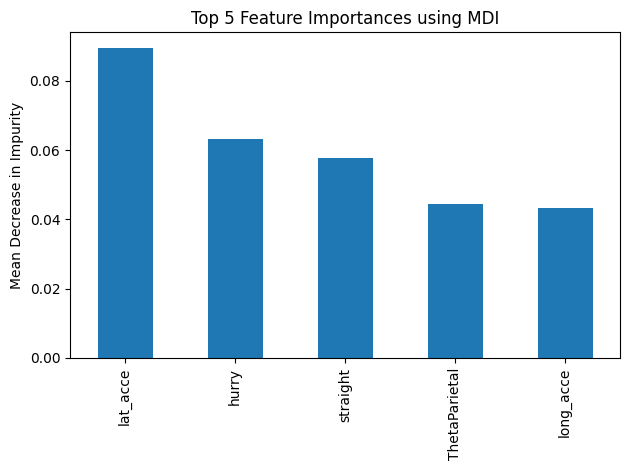

In [ ]:
import pandas as pd

X_train_columns = X_train.columns
# Create a DataFrame with feature importance and corresponding column names
forest_importances = pd.Series(feature_importance, index=X_train_columns)

# Select only the top five most important features
top_five_importances = forest_importances.nlargest(5)

# Plot the top five most important features
fig, ax = plt.subplots()
top_five_importances.plot.bar(ax=ax)
ax.set_title("Top 5 Feature Importances using MDI")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()
plt.show()


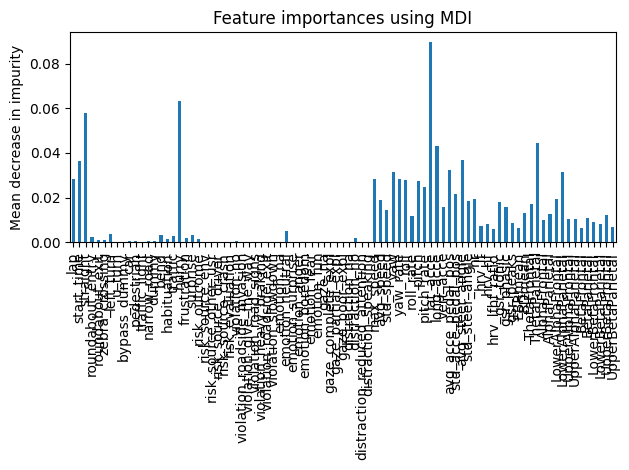

In [ ]:
forest_importances = pd.Series(feature_importance, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# Feature Importance for Gradient Boosted Decision Trees
gbdt_feature_importance = gbdt_grid.best_estimator_.feature_importances_

# Feature Importance for Random Forest
rf_feature_importance = rf_grid.best_estimator_.feature_importances_

# Print feature importance
print("Feature Importance for Gradient Boosted Decision Trees:", gbdt_feature_importance)
print("Feature Importance for Random Forest:", rf_feature_importance)

NameError: name 'gbdt_grid' is not defined

In [ ]:
# For classification
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf_classifier = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf_classifier)
precision_rf = precision_score(y_test, y_pred_rf_classifier)
recall_rf = recall_score(y_test, y_pred_rf_classifier)
f1_rf = f1_score(y_test, y_pred_rf_classifier)


In [ ]:
df = pd.DataFrame(df)
df['future_risk_evaluation'] = df['risk_evaluation'].shift(-1)

In [ ]:
df_filtered = df[~df.duplicated(subset='subject', keep='last')]
df_final = df.drop(df_filtered.index)
df_final = df_final.drop(columns=['Unnamed: 0'])

In [ ]:
df_final.to_csv('fut.csv', sep=',', index=False, encoding='utf-8')

In [ ]:
f1_rf

0.8205128205128205